### This tutorial aims to give a example of prediction of FCPFlow

If you are just starting to learn the FCPFlow model, I recommend reading the tutorial conditioning.ipynb first.

We use NL dataset for this simple experiment

In [9]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alg.tools as tl
import alg.models_fcpflow_lin as fcpf
import torch
from sklearn.preprocessing import  StandardScaler
import properscoring as ps

*load data*

In [10]:
path_train = r'data\train_data_ind.csv'
df = pd.read_csv(path_train, index_col=0)

path_test = r'data\test_data_ind.csv'
df_test = pd.read_csv(path_test, index_col=0)

data_train = torch.Tensor(df.values)
scaler = StandardScaler()
data_scale_train = scaler.fit_transform(data_train)
data_scale_train = torch.Tensor(data_scale_train)

data_scale_test = torch.Tensor(scaler.transform(df_test.values))
cond_test = data_scale_test[:,0:24]
pre_test = data_scale_test[:,24:]


*Define the model*

In [11]:
# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_blocks = 4 
net_type = 'fullconv'
sfactor = 0.5
hidden_dim = 24
w_decay = 0.00

# define the model
num_channels = 24 # resolution of the time series 
condition_dim = 24 # resolution of the condition, load profile of previous day

model = fcpf.FCPflow(num_blocks, num_channels, net_type,  sfactor, hidden_dim, condition_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=w_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100)

mse_o = 1000

*Train the model*

In [12]:
# train the model
for epoch in range(2001):
    model.train()
    
    # data
    data_scale_train  = data_scale_train.to(device) + torch.randn(data_scale_train.shape[0], data_scale_train.shape[1]).to(device)*0.01
    cond = data_scale_train[:,0:condition_dim]
    pre = data_scale_train[:,condition_dim:]
    
    gen, logdet = model(pre, cond)
    
    # compute the log likelihood loss
    llh = tl.log_likelihood(gen, type='Gaussian')
    loss = -llh.mean()-logdet
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # weight clipping
    for p in model.parameters():
        p.data.clamp_(-1, 1)
    
    # save the model
    if epoch % 500 == 0:
        # print the loss
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        
        model.eval()
        z = torch.randn(cond_test.shape[0], num_channels).to(device)
        cond_test = cond_test.to(device)
        gen_test = model.inverse(z, cond_test)
        gen_test = gen_test.cpu().detach().numpy()
        re_data = np.hstack([np.array(cond_test.cpu()), gen_test])
        re_data = scaler.inverse_transform(re_data) # inverse the data
        
        mse = np.mean((re_data[:,24:] - df_test.values[:,24:])**2)
        print('mse {}'.format(mse))
    

epoch 0, loss 21.873921697964295
mse 0.7874562540189293
epoch 500, loss -41.866560394656716
mse 0.07319273493298555
epoch 1000, loss -46.853001013322924
mse 0.07195289866065159
epoch 1500, loss -48.763817551044696
mse 0.0738348060930307
epoch 2000, loss -50.06389588111853
mse 0.08348190662051484


*Select test data*

In [13]:
# load the test data
path_train = r'data\train_data_ind.csv'
df_train = pd.read_csv(path_train, index_col=0)

path_test = r'data\test_data_ind.csv'
df_test = pd.read_csv(path_test, index_col=0)

data_train = torch.Tensor(df_train.values) # fit the scaler

scaler_std = StandardScaler()
data_scale_train_std = scaler_std.fit_transform(data_train)
data_scale_train_std = torch.Tensor(data_scale_train_std)

# pick 3 days
scope =  3
df_3day = df_test[0:scope]
df_3day_pre = df_3day.iloc[:,24:]
df_3day_cond = df_3day.iloc[:,0:24]


df_test_std = scaler_std.transform(df_test)
df_3day_std = df_test_std[0:scope,:]
df_3day_pre_std = df_3day_std[:,24:]
df_3day_cond_std = df_3day_std[:, 0:24]


c:\Users\weijiexia\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


*make prediction*

pinball loss:  0.10866966132562696
MSE:  0.11525356282311108
CRPS:  0.25690989967358224


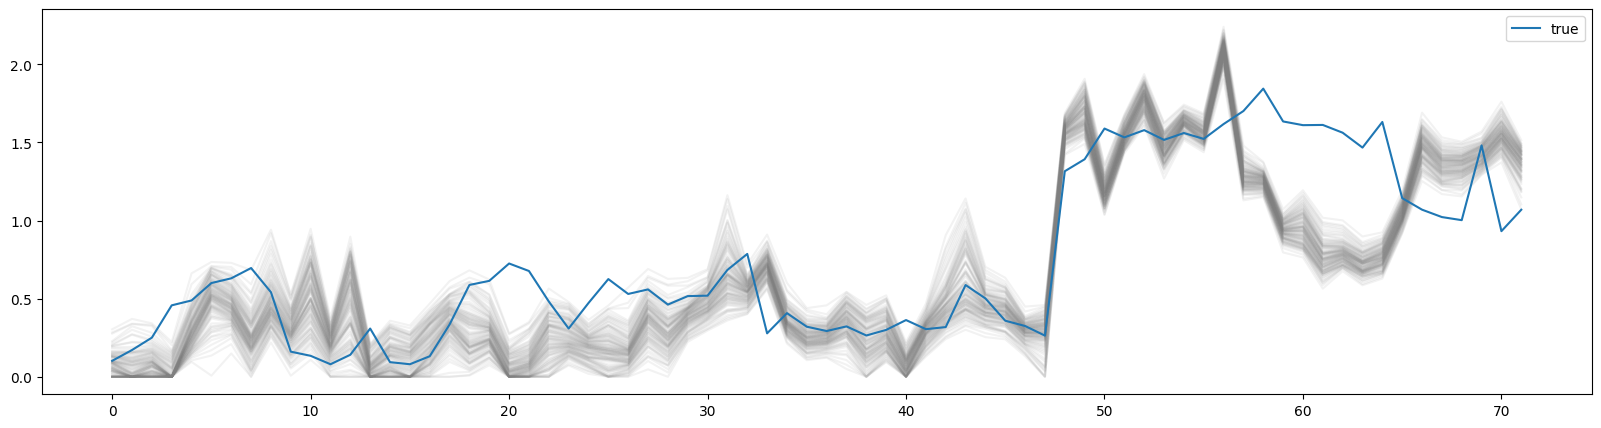

In [14]:
predictions_fct = []
for i in range(200):
    z = torch.randn(df_3day_pre_std.shape[0], num_channels)
    recon = model.inverse(z, torch.tensor(np.array(df_3day_cond_std)))
    recon = recon.cpu().detach().numpy()
    gen_data = np.hstack([np.array(df_3day_cond_std), recon])
    gen_data = scaler_std.inverse_transform(gen_data)
    prediction_fct = gen_data[:,24:]
    prediction_fct[prediction_fct<0 ] = 0
    prediction_fct = prediction_fct.reshape(-1)
    predictions_fct.append(prediction_fct)
    # print(i)
predictions_fct = np.array(predictions_fct)
print('pinball loss: ', tl.plloss(predictions_fct, df_3day_pre.values.reshape(-1)))
print('MSE: ', np.mean((predictions_fct.mean(axis=0) - df_3day_pre.values.reshape(-1))**2))
crps_scores_fct = np.array([ps.crps_ensemble(observation, prediction) for observation, prediction in zip(df_3day_pre.values.reshape(1,-1), predictions_fct)])
print('CRPS: ', crps_scores_fct.mean())

fct_quantiles = tl.compute_quantile(predictions_fct)

# plot the prediction
plt.figure(figsize=(20,5))
# plt.plot(prediction_fct, label='fctflow')
for i in fct_quantiles:
    plt.plot(i, color='grey', alpha = 0.1)
plt.plot(df_3day_pre.values.reshape(-1), label='true')
plt.legend()
plt.show()